In [17]:
#Import dependencies
from citipy import citipy
import random
import requests as req
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [5]:
#_______________________________________________________________________________________________________________
#PartI Obtaining the weather information of ~600 unique cities with randomly chosen latitudes and longtitudes

#Inputs: 1. randomly chosesn (latitudes, longtitudes) numbers

#Steps: 1.Use citipy to find nearest city name and country code for each (latitudes, longtitudes)
#       2.Filter redundant cities
#       3.Make API calls to openweather and retrieve the weather information of all unique cities 

#Outputs.Note I saved all output in a directory called output
#        1. a log.txt file to record names of cities and url while making API calls
#        2. a dictionary to store all the retrieved information as {cityname:response,....}
#           this dictionary will be outputed as a weather_response.txt by json.dump so I do 
#           not need to make more API calls if I want to use pandas to analyze weather info next time
#_________________________________________________________________________________________________________________

#the constant part of url
url='http://api.openweathermap.org/data/2.5/weather?'

#my api key
api='8fcce71da62f06f81dd7b4ec5318540d'

#define a dictionary to store all the weather information
weather_response={}

#define a city list to keep track of cities have retrived from citipy
city_list=[]

#set up a counter only need to retrieve weather information for >500 
count=0

#write a log file
with open('log.txt','a') as txt:
     #I would like to access ~600 cities becaue 600 is a lucky number in Chinese culture
    while count<600:
        #randomly choose x,y as latitude and longtitude from a range (-90,90) and (-180,180) respectively
        x,y=random.uniform(-90,90),random.uniform(-180,180)
        
        #use x,y to identifiy citipy.nearest_city and assign it to a variable nearest_city
        nearest_city=citipy.nearest_city(x,y)
        
        #store city_name and country_code as two variables
        city_name=nearest_city.city_name
        
        country_code=nearest_city.country_code
        
        #get non-redundant cities by using an if statement
        if (city_name,country_code) not in city_list: 
            
            #append only city that has not been in city_list
            city_list.append((city_name,country_code))
            
            #build up a query new city
            query=url+'APPID='+api+'&units=metric&'+'q='+city_name+','+country_code
            
            #make API call as json file
            response=req.get(query).json()
            
            #when you request to get information of cities that are not recorded by openweather,
            #it will respond a message of dictionary as below 
            #{'cod': '404', 'message': 'city not found'} 
            #exclude these ones from recording
            if response!={'cod': '404', 'message': 'city not found'}:
                
                #put only valid response in the weather_response dictionary
                weather_response[city_name]=response
                
                #add one to the counter 
                count+=1
                
                #append a line of record on the log.txt file
                txt.write('Processing record of {} | {} \n {}\n'.format(count,city_name,query))

# dump the weather_response dictionary into an output file  
with open('weather_response.txt','w') as output:
    json.dump(weather_response, output,indent=4)
    

In [19]:
#_______________________________________________________________________________________________________________
#PartII Analyze and visualize retrieved weather info

#Inputs: 1. the weather_response.txt which has all the information from the API calls

#steps: 1.load the weather_response.txt as json file
#       2.extract information needed and make a pandas dataframe
#       3.Plot using matplotlib or seaborn lib

#Outputs. 1. csv file of the data frame
#         2. images of figures
# _______________________________________________

#open input and load as json
#Note I moved the weather_response.txt into a dirctory called output

#get the filepath to input the json file
filepath_json=os.path.join('output','weather_response.txt')

#open json file
with open(filepath_json,'r') as input_json:
    data=json.load(input_json)

#write a df with columns of ['Longtitude','Latitude','Humidity%','Temp','Min_Temp','Max_Temp','Cloudness','City_Name',
# \'Country','Wind_Speed','Date']

#extract all the data above in a row [[all columns for each city],,,,,]
row=[\
     [data[i]['coord'][a] for a in ('lon','lat')]+\
    [data[i]['main'][b] for b in ('humidity','temp','temp_min','temp_max')]+\
   [data[i]['clouds']['all']]+[data[i]['name']]+[data[i]['sys']['country']]+\
   [data[i]['wind']['speed']]+[data[i]['dt']]\
   for i in data.keys()]
weather_df=pd.DataFrame(row,columns=['Longtitude','Latitude','Humidity%','Temp','Min_Temp','Max_Temp','Cloudness','City_Name',\
                                     'Country','Wind_Speed','Date'])

#save all the information to csv file called weather.csv
outfile=os.path.join('output','weather.csv')
weather_df.to_csv(outfile,index=False)

In [20]:
weather_df.head()

Longtitude  Latitude  Humidity%   Temp  Min_Temp  Max_Temp  Cloudness  \
0       82.22     16.73         84  22.08     22.08     22.08          0   
1       58.79     36.21        100   5.56      5.56      5.56         64   
2       -5.72    -15.94        100  22.66     22.66     22.66         80   
3       43.28    -11.38         83  27.00     27.00     27.00         20   
4     -133.03     69.44         90 -15.55    -15.55    -15.55         88   

     City_Name Country  Wind_Speed        Date  
0        Yanam      IN        2.10  1519154556  
1    Neyshabur      IR        1.55  1519154557  
2    Jamestown      SH        6.20  1519154557  
3  Mitsamiouli      KM        2.10  1519149600  
4  Tuktoyaktuk      CA        3.75  1519154558

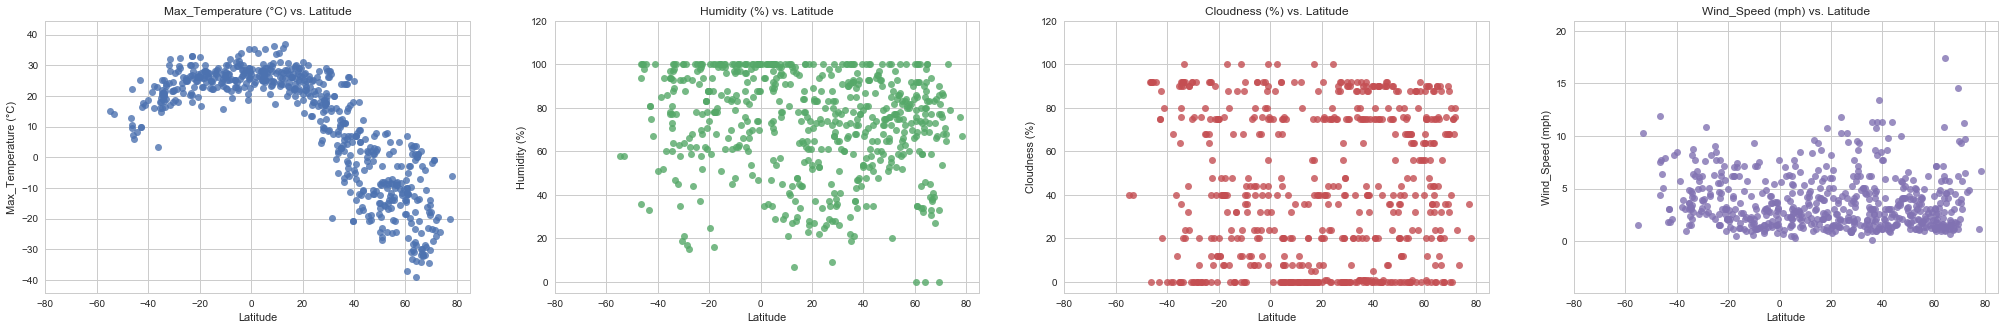

In [37]:
#Create png to show latitudes vs. Max_Temp, Humidity, Cloudiness, Wind Speed
y_data=['Max_Temp','Humidity%','Cloudness','Wind_Speed']

#create a list to stroe y_labels for each ax
y_labels=['Max_Temperature (°C)','Humidity (%)','Cloudness (%)','Wind_Speed (mph)']

#set sns style as white gride
sns.set(style="whitegrid", color_codes=True)

#make a figure with 4 axes 
fig, axs = plt.subplots(figsize=(35,5),ncols=4,sharex=False,sharey=False)

#for loop to plot each axe
for i in range(4):
    #use sns.regplot 
    axs[i]=sns.regplot(x='Latitude',y=y_data[i],data=weather_df,fit_reg=False,ax=axs[i])
    
    #set up limites for each plot
    xmin, xmax, ymin, ymax = axs[i].axis([-80,85,weather_df[y_data[i]].min()-5,weather_df[y_data[i]].max()*1.2])
    
    #set up title for each plot
    axs[i].set_title('{} vs. Latitude'.format(y_labels[i]))
    
    #set up ylabel for each plot
    axs[i].set(ylabel=y_labels[i])

#set up an output_fig
output_fig=os.path.join('output','all_plots.png')

#save the output_figure
plt.savefig(output_fig)

/Users/yizhiyin/AnacondaProjects/API_Homework
